# Focal mechanism calculation using `SKHASH` file format

following code remove the duplicate from the list of velocity models.
I found that `80.0` depth was mentioned twice, so I removed all duplicates using this code.

In [13]:
import numpy as np
import pandas as pd

df = pd.read_csv("./examples/velocity_models_MTJ/vz.MTJ",
                sep="\s+",
                header=None,
                names=['# Depth (km)', 'Vp (km/s)'],
                )

# specify data type of each column to float and make the 2nd column 4 decimal places
df = df.astype({'# Depth (km)': float, 'Vp (km/s)': float})
df['Vp (km/s)'] = df['Vp (km/s)'].map('{:.4f}'.format)

# sort the 1st column in ascending order (increasing depth)
df = df.sort_values(by=['# Depth (km)'])

# remove duplicates in the 1st column
df = df.drop_duplicates(subset=['# Depth (km)'])


df.to_csv("./examples/velocity_models_MTJ/vz.MTJ.txt", index=False)

for i in range(1, 5):
    df.to_csv(f"./examples/velocity_models_MTJ/vz.MTJ{i}.txt", index=False)

IRIS
NCEDC


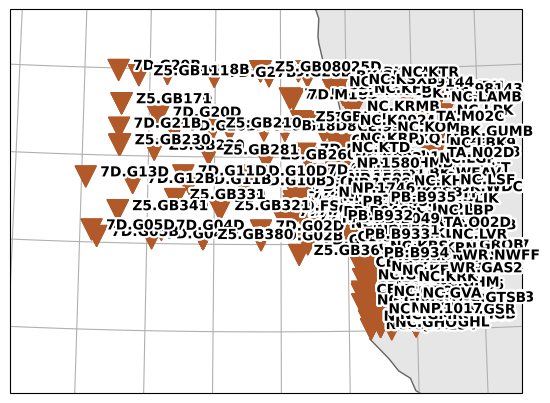

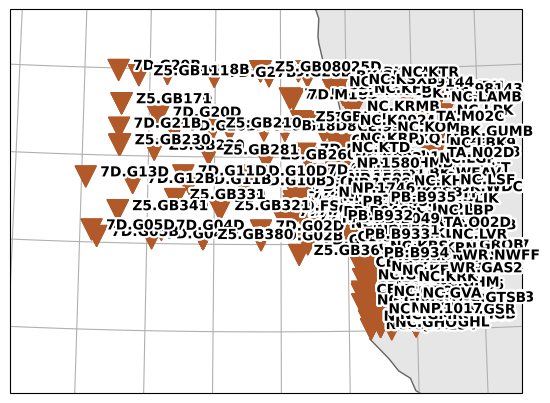

In [1]:
import obspy
from obspy import read, UTCDateTime, read_inventory, Inventory
from obspy.clients.fdsn import Client

# get station inventory
client_list = ['IRIS', 'NCEDC']

starttime = UTCDateTime("2008-01-01")
endtime = UTCDateTime("2023-01-01")

# study area [-125.5, -123, 39.5, 41.5]
minlatitude = 39
maxlatitude = 42
minlongitude = -128
maxlongitude = -122.5



merged_inventory = Inventory()
for iclient in client_list:
    print(iclient)
    client = Client(iclient)
    try:
        try:
            inv = client.get_stations(
                starttime = starttime,
                endtime = endtime,
                minlatitude = minlatitude,
                maxlatitude = maxlatitude,
                minlongitude = minlongitude,
                maxlongitude = maxlongitude,
                channel = 'HH*,BH*,HN*,EH*',
                level = 'response'
            )
            merged_inventory.networks.extend(inv.networks)
        except:
            pass
    except:
        print(f"Failed to get inventory from {iclient}")
        continue
    # inv.write(f"./examples/hash2_MTJ/IN/mtj_{iclient}.txt", format="STATIONTXT")
    merged_inventory.extend(inv)

# merged_inventory.write("./examples/hash2_MTJ/IN/mtj_merged_stations.txt", format="STATIONTXT")



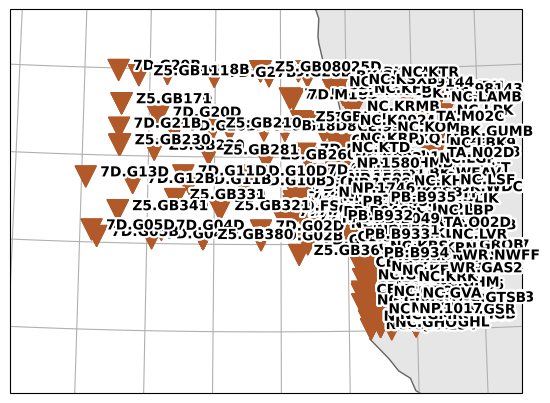

In [2]:
#plot the merged inventory
merged_inventory.plot(projection="local", resolution="i");

In [93]:
sta_df = pd.read_csv(
    "./examples/hash2_MTJ/IN/mtj_merged_stations.txt",
    # skip the first character of first line
    sep='|',
    usecols=[0, 1, 3, 4, 5, 6],
    dtype={'#Network': str, 'Station': str, 'Channel': str, 'Latitude': float, 'Longitude': float, 'Elevation': float},
    header=0,    
)

sta_df = sta_df.rename(columns={'#Network': 'Network'})

sta_df

,Network,Station,Channel,Latitude,Longitude,Elevation
0,5E,CM01A,EH1,40.722698,-123.985397,708.0
1,5E,CM01A,EH2,40.722698,-123.985397,708.0
2,5E,CM01A,EHZ,40.722698,-123.985397,708.0
3,5E,CM02A,EHE,40.660801,-124.168800,122.0
4,5E,CM02A,EHN,40.660801,-124.168800,122.0
...,...,...,...,...,...,...
3246,TA,O02D,HNZ,40.176600,-122.788400,965.0
3247,WR,GAS,EHZ,39.654701,-122.715897,1355.0
3248,WR,NWFF,HNE,39.795750,-122.522248,215.0
3249,WR,NWFF,HNN,39.795750,-122.522248,215.0


In [97]:
formatted_sta_df = sta_df.copy()
formatted_sta_df['Elevation'] = formatted_sta_df['Elevation'].astype(int)

# Create a new text file
output_filename = './examples/hash2_MTJ/IN/mtj_merged.stations.txt'

# Now, read the file and adjust the format according to your requirements
with open(output_filename, 'w') as fid:
    for index, row in formatted_sta_df.iterrows():
        fid.write(f"{row['Network']:2}{' '*2}{row['Station']:<5}{' '*1}{row['Channel']:>3}{' '*(61-13-1)}{row['Latitude']:>9.5f}{' '*1}{row['Longitude']:>10.5f}{' '*1}{row['Elevation']:>5}\n")


# create .reverse file 

In [102]:
stanames = formatted_sta_df.Station.unique()

with open('./examples/hash2_MTJ/IN/mtj_merged.reverse.txt', 'w') as fid:
    for i in range(0, len(stanames)):
            fid.write('{:<5} 19000101 22000101\n'.format(stanames[i]))

In [10]:
# run SKHASH
import os

os.system('python3 SKHASH.py examples/maacama_SKHASH_MTJ/control_file.txt')
# print(os.path.exists('./examples/hash2_MTJ/control_file.txt'))

controlfile : examples/maacama_SKHASH_MTJ/control_file.txt
SKHASH v0.1 (2023-12-15)
Control file: examples/maacama_SKHASH_MTJ/control_file.txt
Creating lookup table (0/0): examples/velocity_models/mvel.txt
	Created table.
Computing mechanisms in serial...
0 / 1	(1)
	S: 318.8509   D: 63.7441   R: 177.9013   U: 27.2059   Q: B
	Runtime: 299.69 sec


9